# XGC Distribution Function Analysis
Contains codes to explore the XGC distribution functions

## Setup

In [18]:
# %% Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [42]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='midplane', **geom_files)

xgcFields = XgcFieldHandler(xgcdata, geom)


# Load phase velocities
tind = 400
uph = np.load('./outputs/phase_vel.npz')['u_lstsq']
interp_uph = scipy.interpolate.CubicSpline(geom.psi_surf, uph[tind,:])

zonalFields = XgcZonalFieldHandler(eq, xgcdata, tind)

## Analysis

In [99]:
# %% Set up constants of motion

## Set up the rotating frame
# NOTE: Be careful about unit conventions, XGC is in sec while we work in millisec

omega_frame = -uph[tind,196]*geom.q_surf[196]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(xgcdata['t'][tind], omega_frame, tind)
t0 = rotating_frame.t0

## Choose which particle properties to use
pp = particle_motion.deut

## Set initial position
#r0 = 2.2259
r0 = eq.interp_router(geom.psi_surf[196]/eq.psix)
z0 = geom.zaxis
x0 = np.array([r0, 0.0, z0])

# Compute magnetic field at initial position
bv = eq.compute_bv(x0[0], x0[2])
modb = np.linalg.norm(bv)
bu = bv / modb

## Compute the rotation frequency and the mean parallel velocity
psi0 = eq.interp_psi.ev(x0[0], x0[2])
omega0 = -zonalFields.interp_phi(psi0, nu=1)*zonalFields.scale_conversion()
vll_mean = eq.interp_ff(psi0) * omega0 / modb

## Determine the initial values of the integrals

# Particle kinetic energy in keV and cos(pitch angle)
ev0 = 0.78
xi0 = np.sqrt(0.33)
# Set the initial parallel velocity
vll0 = vll_mean + pp.vt * xi0 * np.sqrt(ev0)
# Initial magnetic moment
mu0 = pp.m * (1-xi0**2) * (pp.vt * np.sqrt(ev0))**2 / 2 / modb

# Compute initial value of the integrals
ham0, lphi0 = particle_tools.compute_integrals_dk(t0, np.concatenate((x0, [vll0, mu0])), eq, pp, zonalFields, rotating_frame)

In [27]:
# %% Load the reference temperatures and other info that are used for normalization

mesh_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f0.mesh.bp"

with FileReader(mesh_file) as s:
    f0_T_ev = s.read('f0_T_ev')
    f0_smu_max = s.read('f0_smu_max')
    f0_vp_max = s.read('f0_vp_max')

# NOTE: it appears that f0_T_ev[1,:] is the ion temperature
f0_Ti_ev = f0_T_ev[1,:]

In [100]:
# %% Code to load and interpolate the gyrokinetic distribution function

## Load the 
# Load the f_xgc data
f0_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.orbit.f0.08000.bp"

fp_interp = np.zeros(geom.nnode)
fn_interp = np.zeros(geom.nnode)

fp_physical = np.zeros(geom.nnode)
fn_physical = np.zeros(geom.nnode)

f_mask = np.zeros(geom.nnode, dtype=bool)

ksurf0, ksurf1 = 180, 220
#ksurf0, ksurf1 = 194, 197

with FileReader(f0_file) as s:
    # Get number of toroidal planes, and dimension in mu and v_||
    nphi = s.read('nphi')
    nmu = s.read('mudata')
    nvp = s.read('vpdata')

    # Prepare the coordinate grids
    xgc_vpara = np.linspace(-f0_vp_max, f0_vp_max, nvp)
    xgc_vperp = np.linspace(0, f0_smu_max, nmu)

    # Iterate over the nodes
    for knode in tqdm(range(geom.breaks_surf[ksurf0], geom.breaks_surf[ksurf1+1])):
        ## Unmask nodes that we iterate over
        f_mask[knode] = True

        ## Spatial coordinates
        # Get the (R,Z) coordinates of the node
        r, z = geom.rz_node[knode,:]
        # Get varphi of the toroidal plane; note that f0 is on half-integer planes starting at -1/2 (?)
        varphi = 2*np.pi/48 * -0.5

        ## Magnetic geometry stuff
        psi_ev, ff_ev = eq.compute_psi_and_ff(np.array([r]), np.array([z]))
        bv, bu, modb, gradmodb, curlbu = eq.compute_geom_terms(np.array([r]), psi_ev, ff_ev)

        ## Compute normalized velocities
        # Thermal velocity in meters/millisec, which are my unit conventions
        vt = np.sqrt(f0_Ti_ev[knode]*1e-3 / pp.m)
        # Normalized perpendicular velocity
        vperp_n = np.sqrt(2 * mu0 * modb[0] / pp.m) / vt
        # Parallel energy
        kll, pll_mean = particle_tools.compute_parallel_energy(t0, r, z, varphi, mu0, ham0, lphi0, eq, pp, xgcFields, rotating_frame)
        if kll < 0:
            # If parallel energy is negative, skip this node
            f_mask[knode] = False
            continue

        # Positive and negative parallel velocities
        vllp = (pll_mean + np.sqrt(2 * pp.m * kll) / pp.m)
        vlln = (pll_mean - np.sqrt(2 * pp.m * kll) / pp.m)
        vparap_n = vllp / vt
        vparan_n = vlln / vt
        
        ## Load and interpolate the distribution function
        f_xgc = np.squeeze(s.read('i_f', start=[0, 0, knode, 0], count=[1,nmu,1,nvp]))
        xgc_interp = scipy.interpolate.RegularGridInterpolator((xgc_vperp, xgc_vpara), f_xgc, method='cubic')
        fp_interp[knode] = xgc_interp((vperp_n, vparap_n))
        fn_interp[knode] = xgc_interp((vperp_n, vparan_n))

        ## Compute the conversion factor from XGC distribution function to physical distribution function
        bstarp = bv[:,0] + (pp.m / pp.z) * curlbu[0] * vllp
        bstarn = bv[:,0] + (pp.m / pp.z) * curlbu[0] * vlln
        bstarllp = np.sum(bu[:,0]*bstarp, axis=0)
        bstarlln = np.sum(bu[:,0]*bstarn, axis=0)

        fp_physical[knode] = np.sqrt(modb[0]/2/mu0) / bstarllp * fp_interp[knode]
        fn_physical[knode] = np.sqrt(modb[0]/2/mu0) / bstarlln * fn_interp[knode]


fp_physical[np.logical_not(f_mask)] = np.nan
fn_physical[np.logical_not(f_mask)] = np.nan



  0%|          | 0/27043 [00:00<?, ?it/s]

In [101]:
# %% Plot the distribution function


tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 4, 256),1))
twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)

fnorm = (pp.m/(2*np.pi))**(1.5)

f_max = np.max([np.nanmax(fp_physical), np.nanmax(fn_physical)]) * fnorm
f_min = np.min([np.nanmin(fp_physical), np.nanmin(fn_physical)]) * fnorm

#plt.figure()

ksurf = np.searchsorted(-geom.q_surf, 2.0)
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]

fig, axs = plt.subplots(1, 2, width_ratios=[1, 1], figsize=(12, 9), sharex=True, sharey=True)

#geom.rz_tri.set_mask(f_mask)

#ax1 = plt.subplot(121)
axs[0].set_aspect('equal', adjustable='box')
axs[0].tripcolor(geom.rz_tri, fp_physical * fnorm, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)
axs[0].plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

axs[0].set_title(R'$v_\parallel > 0$')

axs[0].set_xlim([1.1, 2.3])
axs[0].set_ylim([-0.95, 0.85])

#ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
axs[1].set_aspect('equal', adjustable='box')
#plt.axis('equal')
pc = axs[1].tripcolor(geom.rz_tri, fn_physical * fnorm, shading='gouraud', rasterized=True, cmap=twr_cmap, vmin=f_min, vmax=f_max)
axs[1].plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

axs[1].set_title(R'$v_\parallel < 0$')

axs[1].set_xlim([1.1, 2.3])
axs[1].set_ylim([-0.95, 0.85])

cax = axs[0].inset_axes([0.6, 0.07, 0.4, 0.01])

plt.colorbar(pc, cax=cax, orientation='horizontal', label='ion gyrocenter distrib. $f_i$')

plt.tight_layout(pad=0.08)

## Test Loading of Data

In [ ]:
# %% Test loading of f0

f0_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.orbit.f0.08000.bp"

with FileReader(f0_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    nodeid = 12000

    # Number of toroidal planes, and dimension in mu and v_||
    nphi = s.read('nphi')
    nmu = s.read('mudata')
    nvp = s.read('vpdata')

    # Load a single distribution function
    f_xgc = s.read('i_f', start=[0, 0, nodeid, 0], count=[1,nmu,1,nvp])
    f_xgc = np.squeeze(f_xgc)



variable_name: i_f 	AvailableStepsCount: 1 	Max: 6.4021e+18 	Min: 2.28167e-304 	Shape: 16, 33, 132048, 33 	SingleValue: false 	Type: double 
variable_name: imu1m1 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: inode1m1 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: iphi 	AvailableStepsCount: 1 	Max: 0 	Min: 0 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: mudata 	AvailableStepsCount: 1 	Max: 33 	Min: 33 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: ndata 	AvailableStepsCount: 1 	Max: 2216 	Min: 2216 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nmup1 	AvailableStepsCount: 1 	Max: 33 	Min: 33 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nnode 	AvailableStepsCount: 1 	Max: 132048 	Min: 132048 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: nphi 	AvailableStepsCount: 1 	Max: 16 	Min: 16 	Shape:  	SingleValue: true 	Type: int

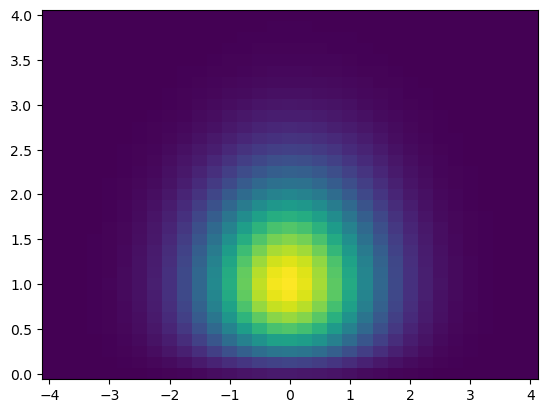

In [ ]:
plt.figure()

vperp_grid = np.linspace(0,4, nmu)
vpara_grid = np.linspace(-4,4, nvp)

plt.pcolormesh(vpara_grid, vperp_grid, f_xgc)

In [19]:
# %% Check data in the mesh file

mesh_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f0.mesh.bp"

with FileReader(mesh_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    f0_T_ev = s.read('f0_T_ev')

variable_name: f0_T_ev 	AvailableStepsCount: 1 	Max: 1195.43 	Min: 0.194034 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_den 	AvailableStepsCount: 1 	Max: 4.64276e+19 	Min: 1.87688e+17 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_dsmu 	AvailableStepsCount: 1 	Max: 0.125 	Min: 0.125 	Shape:  	SingleValue: true 	Type: double 
variable_name: f0_dvp 	AvailableStepsCount: 1 	Max: 0.25 	Min: 0.25 	Shape:  	SingleValue: true 	Type: double 
variable_name: f0_flow 	AvailableStepsCount: 1 	Max: -0 	Min: -0 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_grid_vol_vonly 	AvailableStepsCount: 1 	Max: 14.9034 	Min: 0.00241901 	Shape: 2, 132048 	SingleValue: false 	Type: double 
variable_name: f0_nmu 	AvailableStepsCount: 1 	Max: 32 	Min: 32 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: f0_nvp 	AvailableStepsCount: 1 	Max: 16 	Min: 16 	Shape:  	SingleValue: true 	Type: int32_t 
variable_name: f0_smu_max 	Available

In [7]:
# %% Load 3d field data

# %% Check data in the mesh file

f3d_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.f3d.08000.bp"

with FileReader(f3d_file) as s:
    # inspect variables
    vars = s.available_variables()
    for name, info in vars.items():
        print("variable_name: " + name, end=" ")
        for key, value in info.items():
            print("\t" + key + ": " + value, end=" ")
        print()
    print()

    # Load the ion temperature data
    i_T_perp = s.read('i_den', start=[0, 0], count=[132048, 16])
    i_T_para = s.read('e_den', start=[0, 0], count=[132048, 16])

    # Load field data
    dpot = s.read('dpot', start=[0, 0], count=[132048, 16])

variable_name: dpot 	AvailableStepsCount: 1 	Max: 56.4656 	Min: -27.4515 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_ExB_enflux_en 	AvailableStepsCount: 1 	Max: 6939.91 	Min: -1972.18 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_ExB_flux_en 	AvailableStepsCount: 1 	Max: 3.06801e+19 	Min: -5.69339e+19 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_T_para 	AvailableStepsCount: 1 	Max: 1184.39 	Min: 0.0327014 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_T_perp 	AvailableStepsCount: 1 	Max: 1180.95 	Min: 0.193254 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den 	AvailableStepsCount: 1 	Max: 4.64131e+19 	Min: 5.43334e+15 	Shape: 132048, 16 	SingleValue: false 	Type: double 
variable_name: e_den_en 	AvailableStepsCount: 1 	Max: 1.75574e+19 	Min: 0 	Shape: 132048, 9 	SingleValue: false 	Type: double 
variable_name: e_energy_en 	AvailableStepsCount: 1 	Max: 5.80275e+33

In [26]:
# %% Plot temperature data
%matplotlib qt

tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 16, 256),1))
twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)

plt.figure()

ksurf = np.searchsorted(-geom.q_surf, 2.0)
rz_surf = geom.rz_node[geom.breaks_surf[ksurf]:geom.breaks_surf[ksurf+1],:]

ax1 = plt.subplot(131)
ax1.set_aspect('equal', adjustable='box')
plt.tripcolor(geom.rz_tri, i_T_para[:,0], shading='gouraud', rasterized=True, cmap=twr_cmap)
plt.plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
ax2.set_aspect('equal', adjustable='box')
#plt.axis('equal')
plt.tripcolor(geom.rz_tri, i_T_perp[:,0], shading='gouraud', rasterized=True, cmap=twr_cmap)
plt.plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')

ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
ax3.set_aspect('equal', adjustable='box')
#plt.axis('equal')
plt.tripcolor(geom.rz_tri, dpot[:,0], shading='gouraud', rasterized=True, cmap='PiYG', vmin=-20, vmax=20)
plt.plot(rz_surf[:,0], rz_surf[:,1], c='k', ls=':')